# Demo Convolutional Neural Network (CNN o ConvNet) para procesar imágenes e identificar la clase que corresponde

In [1]:
#@title Librerías a usar
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.utils import plot_model

import random

import keras.backend as K
from tensorflow.keras.preprocessing import image
import cv2
import copy

from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import os

from PIL import Image

from  sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import ipywidgets as widgets
from ipywidgets import Box, Layout

print("Librerías cargadas")

Librerías cargadas


##Imágenes:

In [2]:
#@title Acceder al Drive

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

# directorio local en Google Drive
path = 'gdrive/My Drive/IA/demoIA/ImagenesNumeros' #@param {type:"string"}
path_entrenamiento = '/train'  #@param {type:"string"}
path_prueba = '/test'  #@param {type:"string"}

imagPath_train = path + path_entrenamiento
imagPath_test = path + path_prueba

Mounted at /content/gdrive


> Para Entrenamiento: 
- Clases cargadas:  10
- Imágenes cargadas:  240
- Ejemplo  3   (32, 32, 3) : 


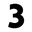



> Para Prueba: 
- Clases cargadas:  10
- Imágenes cargadas:  60
- Ejemplo  4   (32, 32, 3) : 


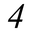

In [3]:
#@title Cargar imágenes

#@markdown ### Parámetros para imágenes:
imagen_ancho =  32#@param {type:"integer"}
imagen_largo =  32#@param {type:"integer"}
imagen_color = True #@param {type:"boolean"}

# tamaño de las imágenes
if imagen_ancho<=10:
  imagen_largo = 10
if imagen_largo<=10:
  imagen_largo = 10
IMAGE_SHAPE = (imagen_ancho, imagen_largo, (3 if imagen_color else 1))

# define función para cargar las imágenes
def cargarImagenes(imagPath):
  classes_ori = []
  images_ori = []

  all_dirs = os.listdir( imagPath )
  for each_dir in all_dirs:

      auxiPath = imagPath + '/' + each_dir
      imagFN  = os.listdir( auxiPath )
      for each_imagFN in imagFN:


            # abre la imagen
            imag = Image.open(auxiPath + "/" + each_imagFN)

            # ajusta el tamaño
            if IMAGE_SHAPE[2]==1:
              tipoImage = 'L'
            else:
              tipoImage = 'RGB'
            imag = imag.convert(tipoImage)
            imag = imag.resize((IMAGE_SHAPE[0], IMAGE_SHAPE[1]), Image.LANCZOS)

            # transforma a un vector de nros
            arImag = np.array(imag)

            # agrega a los vectores
            classes_ori.append( each_dir )
            images_ori.append( arImag )

  return classes_ori, images_ori, tipoImage

# carga las imagenes de entrenamiento
classes_train, images_train, tipoImage_train = cargarImagenes(imagPath_train)
print("> Para Entrenamiento: ")
print("- Clases cargadas: ", len(np.unique(classes_train)))
print("- Imágenes cargadas: ", len(classes_train))

if len(classes_train)>0:
  print("- Ejemplo ", classes_train[0], " ", images_train[0].shape, ": ")
  display( Image.fromarray(images_train[0], tipoImage_train) )

# carga las imagenes de prueba
classes_test, images_test, tipoImage_test = cargarImagenes(imagPath_test)
print("\n\n> Para Prueba: ")
print("- Clases cargadas: ", len(np.unique(classes_test)))
print("- Imágenes cargadas: ", len(images_test))

if len(classes_test)>0:
  print("- Ejemplo ", classes_test[0], " ", images_test[0].shape, ": ")
  display( Image.fromarray(images_test[0], tipoImage_test) )

In [4]:
#@title Ajustar imágenes para reducir el fondo (opcional)

accion_realizar = "-" #@param ["-", "Blur Fondo", "Eliminar Fondo y pasar a Negro", "Eliminar Fondo y pasar a Blanco"]

def cambiarColorNegro(img, nuevoColor=[255, 255, 255]):
    black_pixels = np.where(
        (img[:, :, 0] == 0) &
        (img[:, :, 1] == 0) &
        (img[:, :, 2] == 0)
    )
    img[black_pixels] = nuevoColor
    return img

def blurFondoImagen(im):
  # Convert to the HSV color space
  hsv = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)
  # aplica filtro Otsu threshold para obtener máscara
  ret, maskthresh = cv2.threshold(hsv[:,:,0], 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
  # Genera la máscara negada
  maskthresh = 255 - maskthresh
  # We need a to copy the mask 3 times to fit the frames
  maskthresh = np.repeat(maskthresh[:, :, np.newaxis], 3, axis=2)
  #  Create a blurred frame using Gaussian blur
  blurred_frame = cv2.GaussianBlur(im, (25, 25), 0)
  # Combine the original with the blurred frame based on mask
  return np.where(maskthresh == (255, 255, 255), im, blurred_frame)

def reducirFondoImagen(im):
  # aplica filtro Hue
  imhsv = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)
  # aplica filtro Otsu threshold para obtener máscara
  ret, maskthresh = cv2.threshold(imhsv[:,:,0], 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
  # Genera la máscara negada
  maskthresh = 255 - maskthresh
  # aplica la máscara sobre la imagen
  imgfin = cv2.bitwise_and(im, im, mask = maskthresh)
  return imgfin

def procesarImgRedFondo(imgList):
  nList = []
  for im in imgList:
    if accion_realizar == "Blur Fondo":
      # hacer blur del fondo
      imn = blurFondoImagen(im)
    elif accion_realizar == "Eliminar Fondo y pasar a Negro":
      # eliminar fondo y dejar negro
      imn = reducirFondoImagen(im)
    elif accion_realizar == "Eliminar Fondo y pasar a Blanco":
        # cambia fondo negro a casi negro
        # (para que no cambié después)
        imn = cambiarColorNegro(im, [0, 0, 1])
        # eliminar fondo
        imn = reducirFondoImagen(imn)
        # cambiar fondo a blanco
        imn = cambiarColorNegro(imn, [255, 255, 255])
    else:
      print("Acción no definida!")
      break
    nList.append( imn )
  return nList


# degermina si hace algo o no
if accion_realizar != "-":
  # aplica filtros para intentar reducir el fondo de la imagen
  # cambiando las imágenes disponibles
  images_train = procesarImgRedFondo(images_train)
  images_test = procesarImgRedFondo(images_test)

  if len(classes_train)>0:
    print("- Ejemplo Entrenamiento con fondo reducido ", classes_train[0], " ", images_train[0].shape, ": ")
    display( Image.fromarray(images_train[0], tipoImage_train) )

  if len(classes_test)>0:
    print("- Ejemplo Prueba con fondo reducido ", classes_test[0], " ", images_test[0].shape, ": ")
    display( Image.fromarray(images_test[0], tipoImage_test) )

> Para Entrenamiento: 
 - x_train (cant ejemplos, datos entrada):  (240, 32, 32, 3)
 - y_trainEnc (cant):  240
 - y_train (cant):  240


> Para Prueba: 
 - x_test (cant ejemplos, datos entrada):  (60, 32, 32, 3)
 - y_testEnc (cant):  60
 - y_test (cant):  60


> Para Ambos: 
 - dictMapeo:  {'7': 0, '6': 1, '8': 2, '4': 3, '2': 4, '0': 5, '9': 6, '3': 7, '1': 8, '5': 9}
 - clases_map:  ['7', '6', '8', '4', '2', '0', '9', '3', '1', '5']

 - Imagen reconstruida de  3 ( 7  /  [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.] )


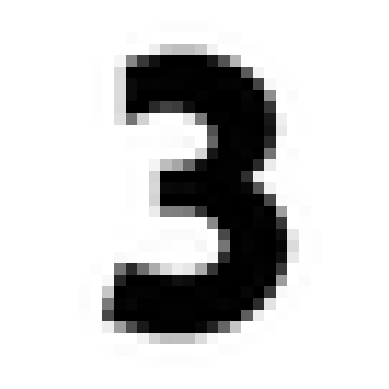

In [5]:
#@title Preparar imágenes para usar en el modelo

# define función auxiliar para mostrar imágenes preparadas
def plot_image(imag):
  if IMAGE_SHAPE[2]==1:
    plt.imshow((imag).reshape(IMAGE_SHAPE[0], IMAGE_SHAPE[1]).astype(np.uint8)) ## *255
    plt.gray()
  else:
    plt.imshow((imag).reshape(IMAGE_SHAPE).astype(np.uint8)) ## *255
  plt.axis("off")

# define función auxiliar para preparar la lista de imágenes a procesar
def prepare_imageList(imagList):
  auxiAr = np.array(imagList) ##.astype('float32') / 255.
  auxiAr = auxiAr.reshape((len(auxiAr), IMAGE_SHAPE[0], IMAGE_SHAPE[1], IMAGE_SHAPE[2]))
  return auxiAr

# define función auxiliar para preparar lista de clases
def prepare_clasesList(classesList, dictMapeo=None):
  if dictMapeo==None:
    # genera diccionario de mapeo
    auxDict = list(set(classesList))
    dictMapeo = dict( zip( auxDict, range(len(auxDict)) ) )
  # realiza el mapeo
  y = []
  for cl in classesList:
      y.append( dictMapeo[cl] )
  # convierte valores numéricos a columnas de vakores binarios (i.e. one hot encoded)
  dummy_y = to_categorical(y)
  # devuelve
  return np.array(y), np.array(dummy_y), dictMapeo

# define vector auxiliar de datos de entrada para usar en el entrenamiento y prueba
x_train = prepare_imageList(images_train)
x_test = prepare_imageList(images_test)

# define vector auxiliar de datos de salida para usar en el entrenamiento y prueba
# también usa esta información para determinar la cantida de neuronas de salida
y_train, y_trainEnc, dictMapeo = prepare_clasesList(classes_train)
y_test, y_testEnc,_ = prepare_clasesList(classes_test, dictMapeo)

# genera diccionario auxiliar para poder convertir de ID de clase a nombre de clase
clases_map = [ x for x,y in dictMapeo.items() ]

print("> Para Entrenamiento: ")
print(" - x_train (cant ejemplos, datos entrada): ", x_train.shape)
print(" - y_trainEnc (cant): ", len(y_trainEnc))
print(" - y_train (cant): ", len(y_train))
print("\n\n> Para Prueba: ")
print(" - x_test (cant ejemplos, datos entrada): ", x_test.shape)
print(" - y_testEnc (cant): ", len(y_testEnc))
print(" - y_test (cant): ", len(y_test))
print("\n\n> Para Ambos: ")
print(" - dictMapeo: ", dictMapeo)
print(" - clases_map: ", clases_map)
if len(y_train)>0:
  print("\n - Imagen reconstruida de ", clases_map[y_train[0]],  "(", y_train[0], " / ", y_trainEnc[0], ")")
  plot_image(x_train[0])

##Modelo:

In [6]:
#@title Establecer capas de Image Augmentation (opcional)

aplicar_da_preProcesamiento = False #@param {type:"boolean"}

#@markdown Nota: estas capas se agregan al modelo para generar automaticamente data augmentation sólo durante el entrenamiento.
da_preProcesamiento_RandomFlip_Horizontal = False #@param {type:"boolean"}
da_preProcesamiento_RandomFlip_Vertical = False #@param {type:"boolean"}
da_preProcesamiento_RandomTranslation_Horizontal_factor = 0.2 #@param {type:"number"}
da_preProcesamiento_RandomTranslation_Vertical_factor = 0.2 #@param {type:"number"}
da_preProcesamiento_RandomRotation_factor = 0.2 #@param {type:"number"}
da_preProcesamiento_RandomZoom_factor = 0.2 #@param {type:"number"}
da_preProcesamiento_RandomContrast_factor = 0.2 #@param {type:"number"}
da_preProcesamiento_RandomBrightness_factor = 0.2 #@param {type:"number"}

daLayers_modelo = []

# capas de data augmentation (solo para training)
if aplicar_da_preProcesamiento:

  if da_preProcesamiento_RandomFlip_Horizontal or da_preProcesamiento_RandomFlip_Vertical:
      if da_preProcesamiento_RandomFlip_Horizontal:
        modeDAFlip = "horizontal"
        if da_preProcesamiento_RandomFlip_Vertical:
          modeDAFlip = modeDAFlip + "_and_vertical"
      else:
        modeDAFlip = "vertical"
      daLayers_modelo.append( tf.keras.layers.RandomFlip(mode=modeDAFlip, seed=None, name="da_rndFlip_"+modeDAFlip) )

  if (da_preProcesamiento_RandomTranslation_Horizontal_factor != 0.0) or (da_preProcesamiento_RandomTranslation_Vertical_factor != 0.0):
    daLayers_modelo.append( tf.keras.layers.RandomTranslation(height_factor=da_preProcesamiento_RandomTranslation_Vertical_factor/100, width_factor=da_preProcesamiento_RandomTranslation_Horizontal_factor, name="da_rndTranslation", fill_mode="nearest") )

  if da_preProcesamiento_RandomRotation_factor != 0.0:
      daLayers_modelo.append( tf.keras.layers.RandomRotation(factor=da_preProcesamiento_RandomRotation_factor, name="da_rndRotation", fill_mode="nearest") )

  if da_preProcesamiento_RandomZoom_factor != 0.0:
    daLayers_modelo.append( tf.keras.layers.RandomZoom(height_factor=da_preProcesamiento_RandomZoom_factor, name="da_rndZoom", fill_mode="nearest") )

  if da_preProcesamiento_RandomContrast_factor != 0.0:
    daLayers_modelo.append( tf.keras.layers.RandomContrast(factor=da_preProcesamiento_RandomContrast_factor, name="da_rndContrast") )

  if da_preProcesamiento_RandomBrightness_factor != 0.0:
    daLayers_modelo.append( tf.keras.layers.RandomBrightness(factor=da_preProcesamiento_RandomBrightness_factor, name="da_rndBrightness") )

# Visualize images and augmentations
cantCapasDA = len(daLayers_modelo) + 2
if cantCapasDA <= 2:
  print("No se aplican capas de Image Augmentation.")
else:
  print("Ejemplo de posibles aplicaciones:")
  fig, ax = plt.subplots(cantCapasDA, 5, figsize=(15,cantCapasDA*3))

  j = 0
  for j in range(5):

    # toma al azar las imágenes a mostrar
    posIm = random.randint(1, len(x_train))
    im = x_train[posIm-1]

    # muestra imagen original
    ax[0][j].imshow((im.astype("uint8")))
    if j == 0:
      ax[0][j].set_title("original")
    ax[0][j].axis('off')

    # muestra imagen con aplicación de capa
    i = 1
    for da_lay in daLayers_modelo:
            ax[i][j].imshow(da_lay(im).numpy().astype("uint8"))
            if j == 0:
              ax[i][j].set_title("sólo capa " + da_lay.name)
            ax[i][j].axis('off')
            i = i + 1

    # aplica todas las capas
    for da_lay in daLayers_modelo:
        im = da_lay(im)

    ax[i][j].imshow(im.numpy().astype("uint8"))
    if j == 0:
      ax[i][j].set_title("TODAS LAS CAPAS")
    ax[i][j].axis('off')

    j = j + 1

  plt.show()

No se aplican capas de Image Augmentation.


Modelo creado con  11  capas:


Model: "ConvNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_img (InputLayer)               │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ slng_1_div_255 (Rescaling)           │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ c_conv_1 (Conv2D)                    │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ p_conv_1 (MaxPooling2D)              │ (None, 11, 11, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ c_conv_2 (Conv2D)                    │ (None, 11, 11, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ p_conv_2 (MaxPooling2D)              │ (None, 4, 4, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ c_conv_3 (Conv2D)                    │ (None, 4, 4, 8)             │           1,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ p_conv_3 (MaxPooling2D)              │ (None, 2, 2, 8)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flat (Flatten)                       │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lineal_1 (Dense)                     │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 10)                  │             330 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,066 (31.51 KB)

 Trainable params: 8,066 (31.51 KB)

 Non-trainable params: 0 (0.00 B)

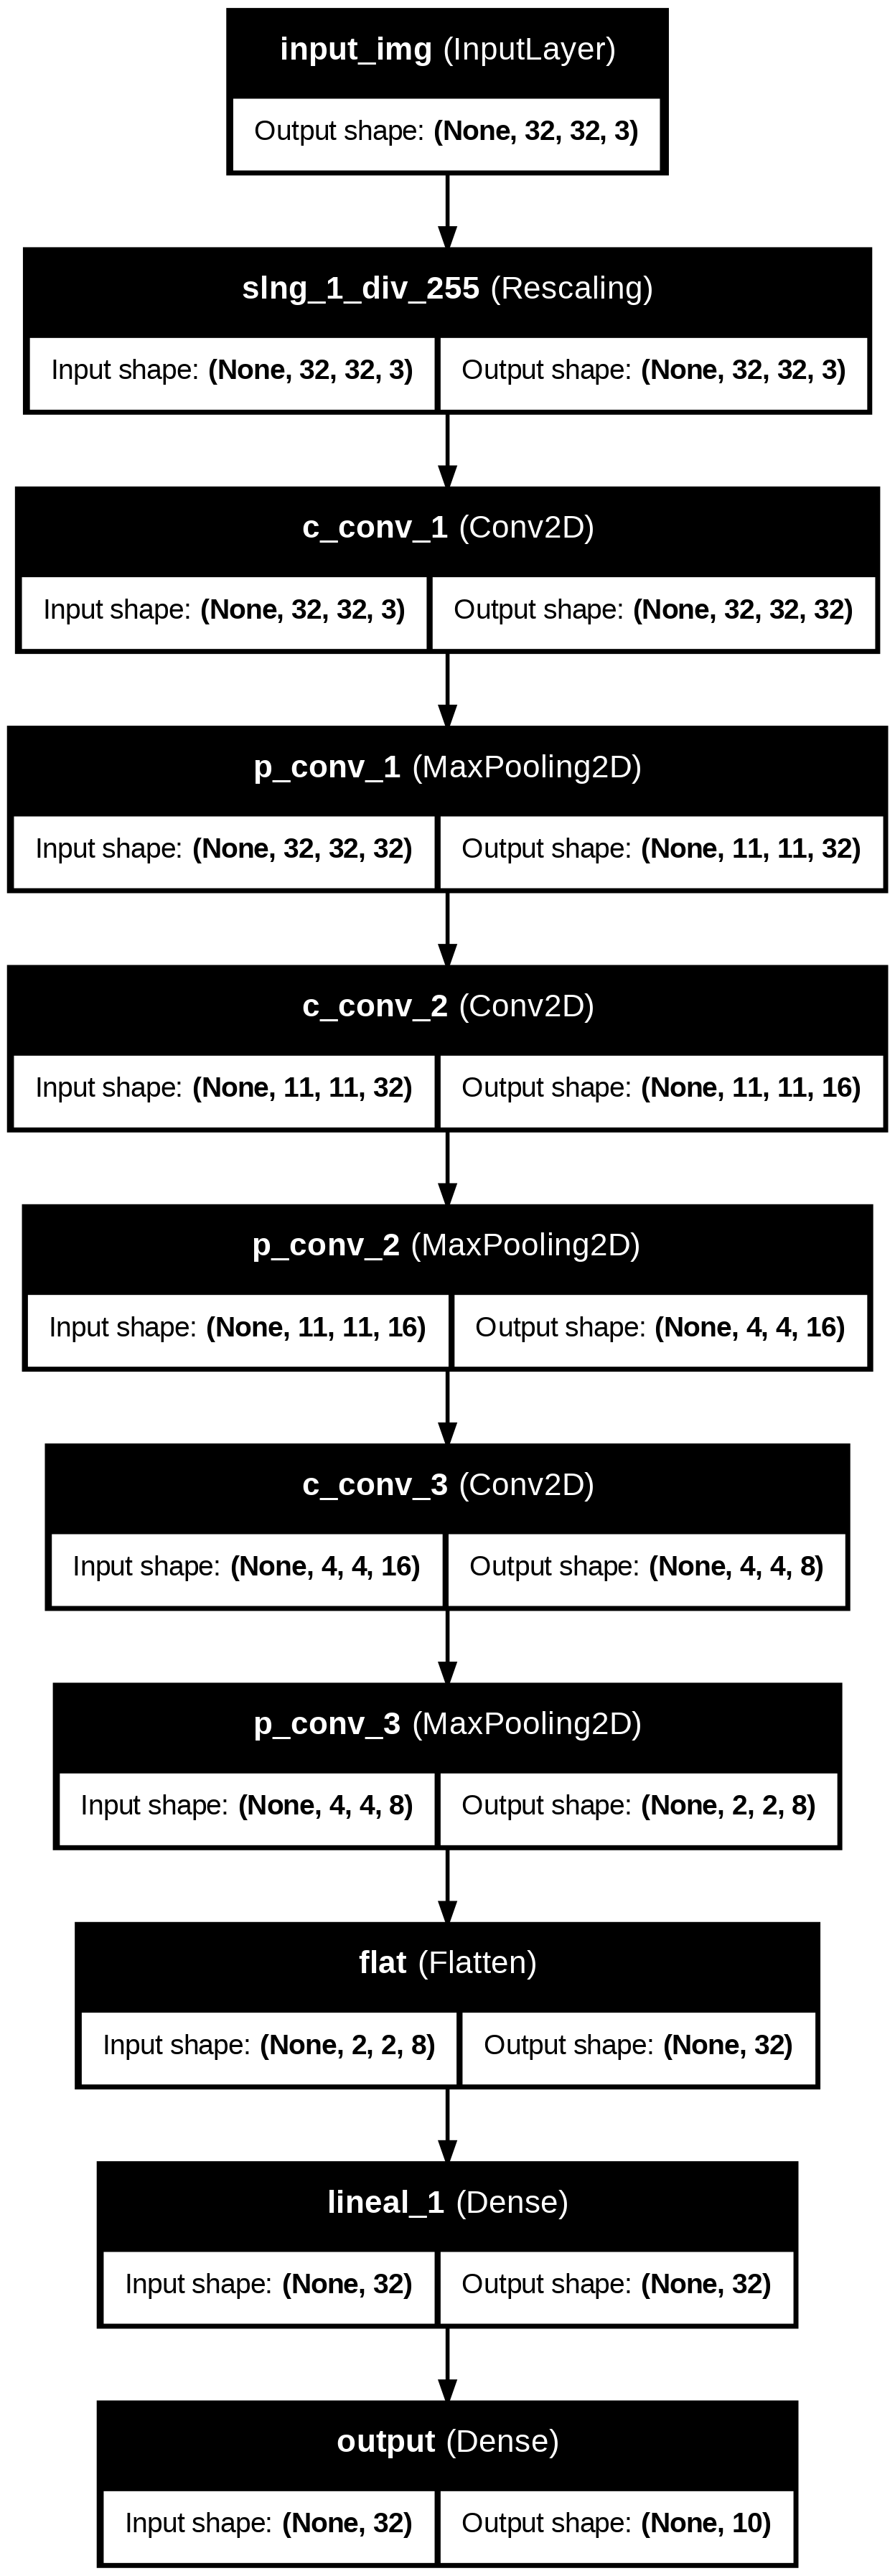

In [54]:
#@title Establecer modelo

#@markdown ### Parámetros de las capas ConvNet:
convNet_tamaño_kernel_NxN =  3 #@param {type:"integer"}
convNet_tamaño_pooling_MxM = 3 #@param {type:"integer"}
convNet_cantidad_capas_ocultas =  3#@param {type:"integer"}
convNet_hacer_Flatten_con_GlobalAveragePooling2D  = False #@param {type:"boolean"}

#@markdown ### Parámetros de las capas Lineales:
lineal_cant_neuronas_capas_ocultas = '32' #@param {type:"string"}
#markdown (Nota: se puede indicar Cantidad de neuronas, D para DropOut, BN para BatchNormalization)
lineal_tipo_funcion = 'relu' #@param ['exponential', 'linear', 'relu', 'sigmoid', 'tanh' ]

lineal_porc_capa_DropOut = 0.4 #param {type:"number"}

red_tipo_capa_salida = 'softmax-MultiClase' #@param ["identidad-Numero", "softmax-MultiClase"]

#@markdown ### Parámetros del Optimizador:
opt_tipo = "Adam" #@param ["Gradiente Decreciente", "Adam", "Adadelta", "Adagrad", "Adamax", "Nadam", "FTRL"]
opt_learning_rate = 0.01 #@param {type: "number"}


## aplicación de los parámetros elegidos

# tamaño de los kernels y pooling (para simplificar son todas iguales)
if convNet_tamaño_kernel_NxN<1:
  convNet_tamaño_kernel_NxN = 1
cnn_kernel_shape = (convNet_tamaño_kernel_NxN, convNet_tamaño_kernel_NxN)
if convNet_tamaño_pooling_MxM<1:
  convNet_tamaño_pooling_MxM=1
cnn_pooling_shape = (convNet_tamaño_pooling_MxM, convNet_tamaño_pooling_MxM)

# indica la configuración para la parte Encoder
#   (cada elemento de las listas son la configuración de las capas Conv)
if convNet_cantidad_capas_ocultas<1:
  convNet_cantidad_capas_ocultas = 1
cnn_filters = []
for i in range(convNet_cantidad_capas_ocultas, 0, -1):
  cnn_filters.append( 2**(i+2) )
last_conv_layer_name = None
last_conv_layer_shape = None

# chequea configuración de drop out
if lineal_porc_capa_DropOut <= 0:
  lineal_porc_capa_DropOut = 0.10
elif lineal_porc_capa_DropOut > 0.9:
    lineal_porc_capa_DropOut = 0.9

# cantidad de neuronas ocultas
hidden_layers = []
for val in lineal_cant_neuronas_capas_ocultas.split(','):
  val = val.strip()
  if val == "D":
    hidden_layers.append( "DropOut" )
  elif val == "BN":
    hidden_layers.append( "BatchNormalization" )
  elif val.isnumeric():
    hidden_layers.append( val )
  else:
    print("Capa ", val, "descartada!")


# define si el tipo de capa de salida es softmax( True )  o lineal ( False )
# esto implica también cambiar cómo se codifican los valores de las clases a usar
tipo_output_softMax = (red_tipo_capa_salida[:7] == 'softmax')

# define la arquitectura de capas de la CNN
# teniendo en cuenta la definición dada anteriomente
input_img_Lay =  tf.keras.layers.Input(shape=IMAGE_SHAPE, name='input_img') # capa de entrada
eachLay = input_img_Lay

# agrega capas de data augmentation si se usan
if len(daLayers_modelo)>0:
  for da_lay in daLayers_modelo:
    eachLay = da_lay(eachLay)

# agrega capa para ajuste de imágenes
eachLay = tf.keras.layers.Rescaling(1./255, name='slng_1_div_255')(eachLay)

auxName = 'conv_'
for i in range(len(cnn_filters)):

    # define el nombre de la capa oculta
    auxlayerName = 'conv_'+str(i+1)

    # agrega las capas ocultas de tipo Conv2D + MaxPooling
    eachLay =  tf.keras.layers.Conv2D(cnn_filters[i], cnn_kernel_shape, activation='relu', padding='same', name='c_'+auxlayerName)(eachLay)
    # determina nombre y shape de la capa conv2D
    last_conv_layer_name = 'c_'+auxlayerName
    last_conv_layer_shape = (eachLay.shape[1], eachLay.shape[2])
    ##print(last_conv_layer_name, last_conv_layer_shape, eachLay.shape)
    eachLay =  tf.keras.layers.MaxPooling2D(cnn_pooling_shape, padding='same', name='p_'+auxlayerName)(eachLay)

#  agrega capa Flatten
if convNet_hacer_Flatten_con_GlobalAveragePooling2D:
  eachLay = tf.keras.layers.GlobalAveragePooling2D(name='flat_GAP')(eachLay)
else:
  eachLay = tf.keras.layers.Flatten(name='flat')(eachLay)

# agrega capas lineales
auxName = 'lineal_'
auxId = 1
for val_hid in hidden_layers:

  if val_hid == "DropOut":
    auxlayerName = "d_"+str(auxId)
    auxId = auxId + 1
    eachLay =  tf.keras.layers.Dropout(lineal_porc_capa_DropOut,name=auxlayerName)(eachLay)
  elif val_hid == "BatchNormalization":
    auxlayerName = "bn_"+str(auxId)
    auxId = auxId + 1
    eachLay =  tf.keras.layers.BatchNormalization(name=auxlayerName)(eachLay)
  elif val_hid.isnumeric():
    # agrega la capa oculta
    auxlayerName = auxName+str(auxId)
    auxId = auxId + 1
    eachLay = tf.keras.layers.Dense(int(val_hid), activation=lineal_tipo_funcion, name=auxlayerName)(eachLay) # capas ocultas

# agrega capa de salida
if tipo_output_softMax:
    # se genera una capa softmax
    output_img_Lay = tf.keras.layers.Dense(units = len(dictMapeo), activation='softmax', name='output')(eachLay) # capa de salida
else:
    # se genera una capa lineal con una salida numérica
    output_img_Lay = tf.keras.layers.Dense(1, activation=None, name='output')(eachLay) # capa de salida

if opt_tipo == "Gradiente Decreciente":
  opt = keras.optimizers.SGD(learning_rate=opt_learning_rate)
elif opt_tipo == "Adam":
  opt = keras.optimizers.Adam(learning_rate=opt_learning_rate)
elif opt_tipo == "Adadelta":
  opt = keras.optimizers.Adadelta(learning_rate=opt_learning_rate)
elif opt_tipo == "Adagrad":
  opt = keras.optimizers.Adagrad(learning_rate=opt_learning_rate)
elif opt_tipo == "Adamax":
  opt = keras.optimizers.Adamax(learning_rate=opt_learning_rate)
elif opt_tipo == "Nadam":
  opt = keras.optimizers.Nadam(learning_rate=opt_learning_rate)
elif opt_tipo == "FTRL":
  opt = keras.optimizers.Ftrl(learning_rate=opt_learning_rate)
else:
  opt = keras.optimizers.Adam()

# genera el modelo ConvNet
model = Model(input_img_Lay, output_img_Lay, name='ConvNet')
if tipo_output_softMax:
    # utiliza un loss de multiple clases
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
else:
    # utiliza un loss de valor numérico
    model.compile(optimizer=opt, loss='mse', metrics=['accuracy'])

print("Modelo creado con ", len(model.layers), " capas:")
model.summary()
print("\n")
plot_model(model, show_layer_names=True, show_shapes=True)

In [55]:
#@title Entrenar

cant_epocas_entrenamiento =  35#@param {type:"integer"}

activar_corte_por_estabilidad_val_loss = False #@param {type:"boolean"}


# cantidad de épocas del entrenamiento
cantEpocas = (1 if cant_epocas_entrenamiento<1 else cant_epocas_entrenamiento)


# separa al azar usando muestreo al azar del 10%
# para tomar algunos como datos de validación
x_t, x_v, y_t, y_v = train_test_split(x_train,
                                       (y_trainEnc if tipo_output_softMax else y_train),
                                       test_size=0.1, shuffle=True)

print("\n> De los ", len(x_train), "ejemplos de entrenamiento: ")
print("            se usan ", len(x_t), "ejemplos para entrenar ")
print("            y ", len(x_v), "ejemplos para validar.")

print("\n\n>Comienza el Entrenamiento:")


if activar_corte_por_estabilidad_val_loss:
  # se agrega un callBack para que corte
  # si el error de validación no sigue bajando
  # y devuelva los mejores pesos obtenidos
  early_stopping_monitor = keras.callbacks.EarlyStopping(
      monitor='val_loss',
      min_delta=0.01,
      patience=20,
      verbose=1,
      mode='min',
      baseline=None,
      restore_best_weights=True,
      start_from_epoch=5
  )
  callbacksEntr = [early_stopping_monitor]
else:
  early_stopping_monitor = None
  callbacksEntr = []

# lleva a cabo el entrenamiento
history = model.fit(x_t, y_t,
          epochs = cantEpocas,
          validation_data=(x_v, y_v,),
          callbacks=callbacksEntr )

print("\n>Entrenamiento Finalizado.")



> De los  240 ejemplos de entrenamiento: 
            se usan  216 ejemplos para entrenar 
            y  24 ejemplos para validar.


>Comienza el Entrenamiento:
Epoch 1/35
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - accuracy: 0.1262 - loss: 2.3199 - val_accuracy: 0.1250 - val_loss: 2.3032
Epoch 2/35
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.1126 - loss: 2.2972 - val_accuracy: 0.2083 - val_loss: 2.3103
Epoch 3/35
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.3376 - loss: 2.2286 - val_accuracy: 0.0833 - val_loss: 2.2741
Epoch 4/35
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.2669 - loss: 1.9574 - val_accuracy: 0.2083 - val_loss: 1.9355
Epoch 5/35
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.4702 - loss: 1.5184 - val_accuracy: 0.5833 - val_loss: 1.4773
Epoch 6/35
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6070 - loss: 1.1239 - val_accuracy: 0.6667 - val_loss: 1.2762
Epoch 7/35
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7172 - loss: 0.8165 - va

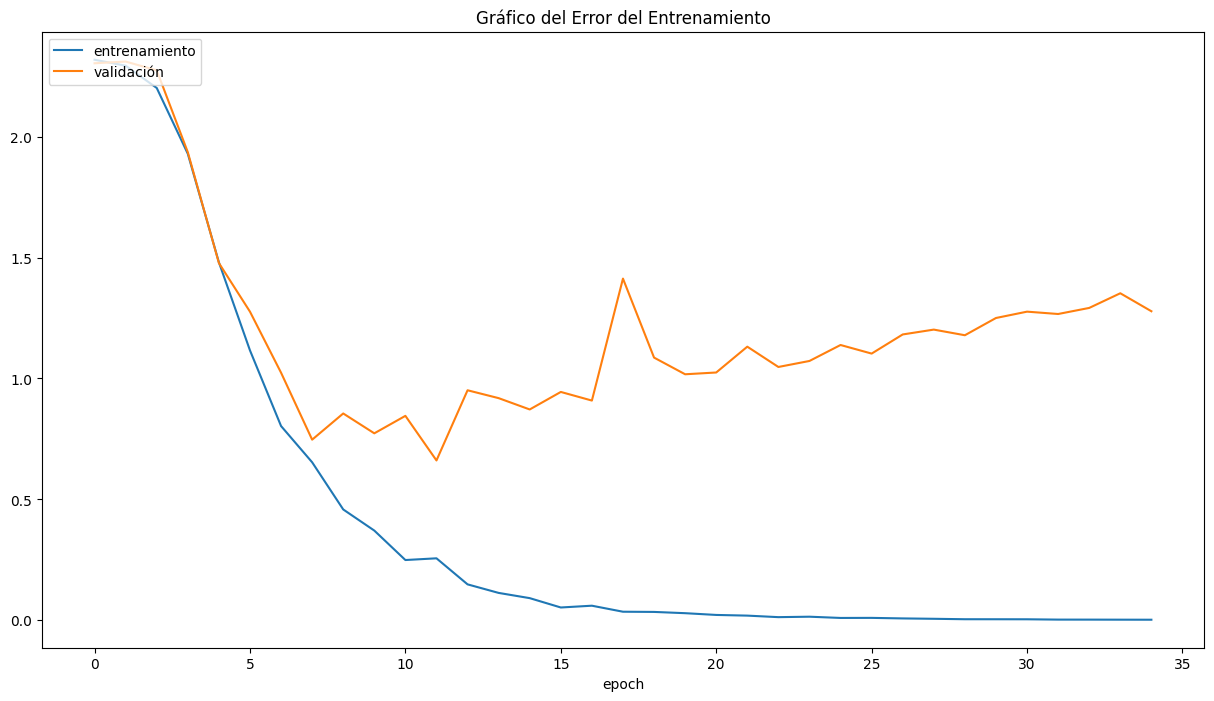

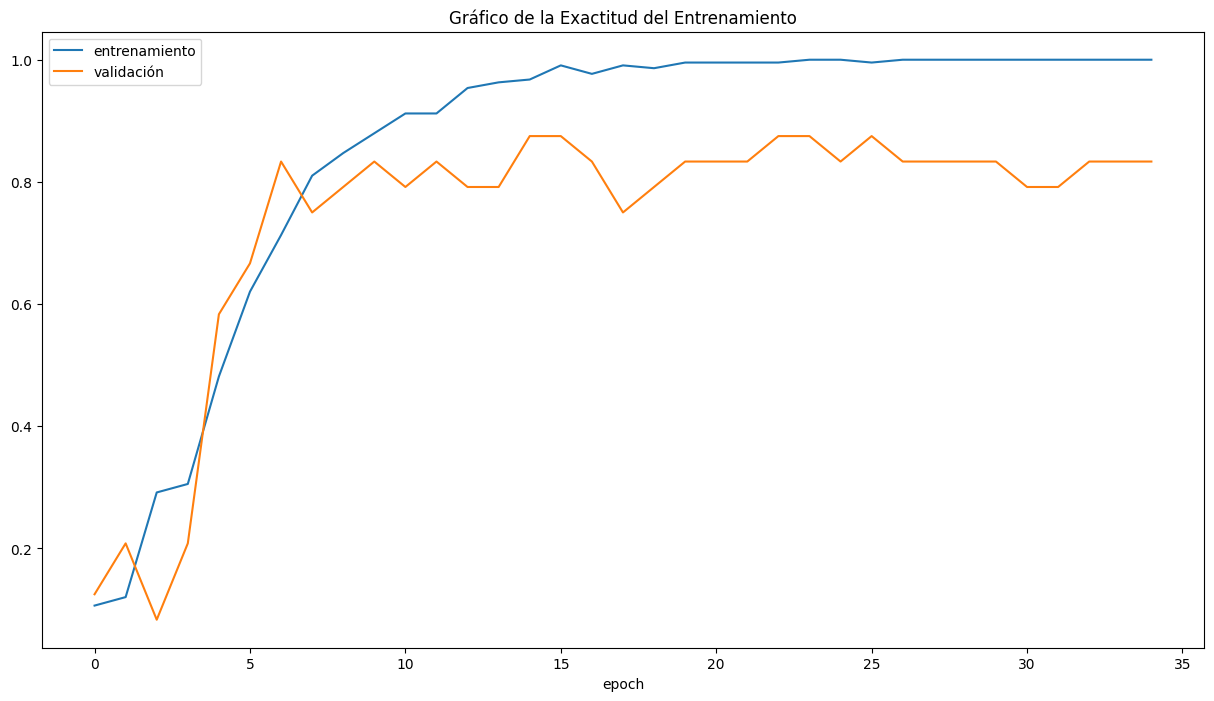

In [56]:
#@title Mostrar Gráficos del Entrenamiento
plt.figure(figsize=(15,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Gráfico del Error del Entrenamiento')
plt.ylabel('')
plt.xlabel('epoch')
plt.legend(['entrenamiento', 'validación'], loc='upper left')
plt.show()

plt.figure(figsize=(15,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Gráfico de la Exactitud del Entrenamiento')
plt.ylabel('')
plt.xlabel('epoch')
plt.legend(['entrenamiento', 'validación'], loc='upper left')
plt.show()

In [57]:
#@title Evaluar red entrenada con datos de entrenamiento


# explicación y fuente de GradCAM en:
#   https://medium.com/analytics-vidhya/visualizing-activation-heatmaps-using-tensorflow-5bdba018f759
def prepareGradCAM(model, last_conv_layer_name):
  # genera sub-modelo desde capa de entrada a última capa convultional
  last_conv_layer = model.get_layer(last_conv_layer_name)
  subModel = tf.keras.models.Model([model.inputs], [model.output, last_conv_layer.output])
  return subModel

def aplicarGradCAM(subModel, last_conv_layer_shape, imgOrig, intensity=0.5, res=250):
  # prepara la imagen a procesar
  img = copy.deepcopy(imgOrig)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  # genera el heatmap
  with tf.GradientTape() as tape:
    model_out, last_conv_layer = subModel(x)
    class_out = model_out[:, np.argmax(model_out[0])]
    grads = tape.gradient(class_out, last_conv_layer)
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
  heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  heatmap = heatmap.reshape(last_conv_layer_shape) # (8, 8))
  # aplica el heatmap
  imgHM = copy.deepcopy(imgOrig)
  heatmap = cv2.resize(heatmap, (imgHM.shape[1], imgHM.shape[0]))
  heatmap = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
  imgHM = heatmap * intensity + imgHM
  # devuelve imagen con HeatMap
  return imgHM

# función auxiliar para probar el modelo entrenado en detalle
def probarModelo(x, y, clases_map, tipo_output_softMax, umbralClas=50.0, mostrarGradCAM=False, rtdo="TODOS", cantMostrar="TODAS", claseFiltrar=None):

    # determina clase a filtrar
    if (claseFiltrar is None) or (claseFiltrar == "-"):
          clFiltrarID = None
          mostrarImagenes = False
    elif (claseFiltrar == "TODOS"):
          clFiltrarID = None
          mostrarImagenes = True
    else:
          clFiltrarID = dictMapeo[claseFiltrar]
          mostrarImagenes = True
    if umbralClas <= 0.0:
      umbralClas = 0.1
    elif umbralClas >= 100.0:
      umbralClas = 99.0
    else:
      umbralClas = umbralClas/100.0

    # determina tipo de resultado a mostrar
    if rtdo == "Clasificación Incorrecta":
      tipoRes = -1
    elif rtdo == "Clasificación Correcta":
      tipoRes = 1
    else:
      tipoRes = 0


    if mostrarGradCAM:
      # genera submodelo
      subModel = prepareGradCAM(model, last_conv_layer_name)
      # si muestra GradCAM también muestra imagen original
      mostrarImagenes = True

    # determina cantidad a mostrar
    if (cantMostrar == "TODAS"):
      cantMostrar = len(x)
    elif (cantMostrar <= 0):
      cantMostrar = 0
      mostrarImagenes = False

    # procesa las imágenes de prueba con el modelo
    predClass = model.predict(x, verbose=0)

    # lista auxiliar para mostrar
    imgsParaMostrar = []

    # muestra los resultados con las imágenes
    classPreds = []
    classReal = []
    for i in range(len(x)):

        # asigna el nombre de la clase real
        clReal = clases_map[ y[i] ]

        # determina la clase predecida
        if tipo_output_softMax:
            ## determina clase predecida de acuerdo a la que tiene mayor valor
            idclPred = int( np.argmax(predClass[i], axis=0) )
            idclPredRnd = idclPred
        else:
            ## determina clase predecida de acuerdo al umbral de clasificación
            idclPred = predClass[i][0]
            idclPredRnd = int(idclPred)
            if (idclPred - idclPredRnd)>umbralClas and (idclPredRnd+1)<len(clases_map):
                  idclPredRnd = idclPredRnd + 1

        # asigna el nombre de la clase predecida
        if idclPredRnd<0 or idclPredRnd>=len(clases_map):
            clPred = "CLASE " + str(idclPredRnd) + " INVÁLIDA!"
        else:
            clPred = clases_map[ idclPredRnd ]

        # agrega a vevtores auxiliares
        classReal.append( clReal )
        classPreds.append( clPred )
        resClasOK = (clReal==clPred)

        if mostrarImagenes:

          # determina si filtra por clase
          if (clFiltrarID is None) or (clFiltrarID == y[i]):

            # filtra por tipo de resultado
            if (tipoRes==0) or \
              ((tipoRes > 0) and resClasOK) or\
              ((tipoRes < 0) and not(resClasOK)):
                # el titulo par aponer en la imagen
                strTitulo = 'Real: ' + str(clReal) + ' / Modelo: ' + str(clPred)
                if not resClasOK:
                  strTitulo = strTitulo + "!"
                #strTitulo = strTitulo + clPred + ' (' + str( idclPred ) +')'

                # agrega para mostrar
                imgsParaMostrar.append( [strTitulo, x[i] ] )


    # cierra la imagen
    if mostrarImagenes and (cantMostrar>0) and (len(imgsParaMostrar)>0):
      print("\n>Detalle: ")

      if cantMostrar >= len(imgsParaMostrar):
        # muestra todas
        eligeImAlAzar = False
        cantMostrar = len(imgsParaMostrar)
      else:
        # muestra al azar
        eligeImAlAzar = True

      # prepara para mostrar imagenes
      if mostrarGradCAM:
        nCols = 2
        nRows = cantMostrar
        plt.figure(figsize=(5, 3*nRows))
      else:
        nCols = 3
        nRows = cantMostrar // nCols
        if (nRows*nCols) < cantMostrar:
          nRows = nRows + 1
        plt.figure(figsize=(10, 3*nRows))
      posImagen = 1

      for i in range(cantMostrar):
            # elige al azar o no para mostrar
            if eligeImAlAzar:
              posIm = random.randint(1, len(imgsParaMostrar))-1
            else:
              if i >= len(imgsParaMostrar):
                break
              else:
                posIm = i
            # determina datos a mostrar
            im = imgsParaMostrar[posIm][1]
            tit = imgsParaMostrar[posIm][0]

            # muestra la imagen
            ax = plt.subplot(nRows, nCols, posImagen)
            plot_image( im )
            plt.title( tit, fontsize=9 )
            posImagen = posImagen + 1

            # muestra resultado aplicar GRADCAM
            if mostrarGradCAM:
              imgGradCAM = aplicarGradCAM(subModel, last_conv_layer_shape, im)
              ax = plt.subplot(nRows, nCols, posImagen)
              plot_image( imgGradCAM )
              posImagen = posImagen + 1

            # saca elemento de la lista para no elegirlo al azar de nuevo
            if eligeImAlAzar:
              if len(imgsParaMostrar) > posIm:
                imgsParaMostrar.pop( posIm )

      #plt.tight_layout()
      fig = plt.gcf()
      plt.show()
      plt.close(fig)

    # muestra reporte de clasificación
    print("\n Reporte de Clasificación: ")
    print(classification_report(classReal, classPreds))

    # muestra matriz de confusion
    print('\nMatriz de Confusión ( real / modelo ): ')
    cm = confusion_matrix(classReal, classPreds, labels=clases_map)
    cmtx = pd.DataFrame(
        cm,
        index=['r:{:}'.format(x) for x in clases_map],
        columns=['m:{:}'.format(x) for x in clases_map]
      )
    cmtx.sort_index(axis=0, inplace=True)
    cmtx.sort_index(axis=1, inplace=True)
    print(cmtx)
    print("\n")


# genera toda la interface para evaluar modeo DAE
def crearUI_evaluarModelo(clDefecto, clases, ruidoPorDefecto, funcionCambiaSeleccion):

  # auxiliar para que muestre bien la descripción
  style_3D = {'description_width': 'initial'}
  childrenList = []

  slider_umbral = widgets.FloatSlider(
      value=50,
      min=0,
      max=100.0,
      step=1.0,
      description='Umbral de Clasificación: ',
      disabled=False,
      continuous_update=False,
      orientation='horizontal',
      readout=True,
      style=style_3D,
      readout_format='.1f',
  )
  if not tipo_output_softMax:
    childrenList.append( slider_umbral )

  # prepara combo para filtrar por clase
  seleccion_CLASES = ["-", "TODOS"]
  seleccion_CLASES.extend( clases )
  seleccion_CLASES.sort()
  combo_clase = widgets.Dropdown(
      options = seleccion_CLASES,
      value = clDefecto,
      description = 'Filtrar por clase:',
      style=style_3D,
      disabled = False,
  )
  childrenList.append( combo_clase )

  # prepara combo para filtrar por resultado
  selecc_resutado = [ "TODOS", "Clasificación Incorrecta", "Clasificación Correcta" ]
  combo_resultado = widgets.Dropdown(
      options = selecc_resutado,
      value = selecc_resutado[0],
      description = 'Filtrar por resultado:',
      style=style_3D,
      disabled = False,
  )
  childrenList.append( combo_resultado )

  # prepara combo para filtrar por cantidad
  selecc_cantidad = [ 3 ]
  selecc_cantidad.extend( range(6, 151, 9) )
  selecc_cantidad.append( "TODAS" )
  combo_cantidad = widgets.Dropdown(
      options = selecc_cantidad,
      value = 6,
      description = 'Mostrar N imágenes al azar:',
      style=style_3D,
      disabled = False,
  )
  childrenList.append( combo_cantidad )

  mostrar_HeatMap_de_GradCAM = widgets.Checkbox(
        value=False,
        description='Mostrar HeatMap de GradCAM',
        disabled=False
    )
  #childrenList.append( mostrar_HeatMap_de_GradCAM )


  prueba_ui = widgets.GridBox(children=childrenList,
          layout=Layout(width='100%')
        )
  out_prueba = widgets.interactive_output(funcionCambiaSeleccion, {'cant':combo_cantidad, 'rtdo': combo_resultado,'cl':combo_clase, 'h':mostrar_HeatMap_de_GradCAM, 'umbralClas':slider_umbral})

  return prueba_ui, out_prueba

# función para filtrar por clase
def cambiaSeleccion_clase_evaluar_imEntrenamiento(cant, rtdo, cl, h, umbralClas):

    # prueba con los datos de entrenamiento
    print("\n\n*** Resultados con datos de Entrenamiento: ")
    probarModelo(x_train, y_train, clases_map, tipo_output_softMax, umbralClas, h, rtdo, cant, cl)

# muestra la interface
ev_entrenamiento_ui, ev_entrenamiento_out = crearUI_evaluarModelo( "-", clases_map, 0.0, cambiaSeleccion_clase_evaluar_imEntrenamiento)
display(ev_entrenamiento_ui, ev_entrenamiento_out)


GridBox(children=(Dropdown(description='Filtrar por clase:', options=('-', '0', '1', '2', '3', '4', '5', '6', …

Output()

In [58]:
#@title Evaluar red entrenada con datos de prueba

# función para filtrar por clase
def cambiaSeleccion_clase_evaluar_imEntrenamiento(cant, rtdo, cl, h, umbralClas):

  # prueba con los datos de prueba
  print("\n\n*** Resultados con datos de Prueba: ")
  probarModelo(x_test, y_test, clases_map, tipo_output_softMax, umbralClas, h, rtdo, cant, cl)

# muestra la interface
ev_entrenamiento_ui, ev_entrenamiento_out = crearUI_evaluarModelo( "-", clases_map, 0.0, cambiaSeleccion_clase_evaluar_imEntrenamiento)
display(ev_entrenamiento_ui, ev_entrenamiento_out)


GridBox(children=(Dropdown(description='Filtrar por clase:', options=('-', '0', '1', '2', '3', '4', '5', '6', …

Output()